In [251]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from toolz import partial, valmap
from pathlib import Path
from aging.plotting import format_plots, figure, legend, add_identity
import colorcet as cc
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge

In [2]:
def reindex_c(df1, df2):
    return df1.reindex(columns=df2.columns).fillna(0)

In [3]:
dotted_identity = partial(add_identity, linestyle='--', color='k')

In [4]:
format_plots()

In [5]:
version = 8
folder = Path(f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}")

In [185]:
!ls {str(folder)}

all_data_pca
dlight_syllable_df_v00.parquet
longtogeny_extra_females.parquet
longtogeny_males_clean_v1.parquet
longtogeny_males_clean_v2.parquet
longtogeny_males_syllable_df_v00.parquet
longtogeny_v2_females_syllable_df_v00.parquet
longtogeny_v2_males_syllable_df_v00.parquet
longv2_females_clean_v1.parquet
longv2_females_clean_v2.parquet
longv2_males_clean_v1.parquet
longv2_males_clean_v2.parquet
model_params.p
ontogeny_females_clean_v1.parquet
ontogeny_females_clean_v2.parquet
ontogeny_females_syllable_df_v00.parquet
ontogeny_males_clean_pseudotime_v02.parquet
ontogeny_males_clean_v1.parquet
ontogeny_males_clean_v2.parquet
ontogeny_males_syllable_df_v00.parquet
_pca
training_data
wheel_clean.parquet
wheel_syllable_df_v00.parquet


In [186]:
# usages = pd.read_parquet(folder / "ontogeny_males_clean_v2.parquet").fillna(0).astype('float32')
usages = pd.read_parquet(folder / "ontogeny_males_clean_pseudotime_v02.parquet").fillna(0).astype('float32')
long_usages = pd.read_parquet(folder / "longtogeny_males_clean_v1.parquet").fillna(0).astype('float32')
long_usages = long_usages[long_usages.index.get_level_values('age') < 600]

In [7]:
keep_syll = usages.quantile(0.9) > 0.01
keep_syll = keep_syll[keep_syll].index

In [189]:
age = usages.index.get_level_values('pseudo_age')
long_age = long_usages.index.get_level_values('age') / 7

### Make ontogeny regressor

In [294]:
# model_sylls = [0, 1, 8, 11, 16, 18, 19, 20, 27, 28, 29, 37, 38, 43, 44, 50, 56, 58, 71, 73]
# model_sylls = [0, 1, 8, 11, 18, 19, 20, 27, 28, 29, 37, 44, 50, 56, 58, 71]
model_sylls = [0, 1, 8, 11, 16, 19, 20, 27, 29, 34, 37, 38, 43, 50, 55, 56, 58, 64, 65, 71]

In [295]:
pipeline = make_pipeline(StandardScaler(), PLSRegression(n_components=2))
pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=15, metric="euclidean"))
pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), KernelRidge(kernel='poly', alpha=0.63, degree=3, gamma=0.01))

In [296]:
# pipeline.fit(usages[keep_syll], age)
pipeline.fit(usages[model_sylls], age)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('kernelridge',
                 KernelRidge(alpha=0.63, gamma=0.01, kernel='poly'))])

In [297]:
kernel = 1 * RBF(length_scale=5e2, length_scale_bounds=(1e-4, 1e3))

out = {}

for mouse, _df in tqdm(long_usages.groupby("mouse")):
    x = _df.index.get_level_values("age") / 7
    mouse_preds = {}
    for syll in model_sylls:
        y = _df[syll]
        gp = GaussianProcessRegressor(
            kernel=kernel, n_restarts_optimizer=10, alpha=0.55, normalize_y=True
        )
        gp.fit(x.to_numpy().reshape(-1, 1), y)
        mouse_preds[syll] = pd.Series(gp.predict(x.to_numpy().reshape(-1, 1)), index=x)
    out[mouse] = mouse_preds

  0%|          | 0/16 [00:00<?, ?it/s]

In [298]:
mouse_df_dict = valmap(pd.DataFrame, out)
mouse_pred_dict = valmap(lambda v: pd.Series(pipeline.predict(v), index=v.index), mouse_df_dict)

In [299]:
valmap(lambda v: r2_score(v.index, v), mouse_pred_dict)

{'01_01': 0.7821293009128075,
 '01_02': 0.8892710074281814,
 '01_03': 0.8290903152764153,
 '01_04': 0.5855480057153046,
 '02_01': 0.8850886918721488,
 '02_02': 0.874804794485276,
 '02_03': 0.6790516179578219,
 '02_04': 0.797425136628463,
 '03_01': 0.6963959802877282,
 '03_02': 0.9211767039682281,
 '03_03': 0.6589657924080471,
 '03_04': 0.6230257581728674,
 '04_01': 0.48705462568962865,
 '04_02': 0.800472664467127,
 '04_03': 0.7907786300060577,
 '04_04': 0.20100989022165006}

In [300]:
concat = pd.concat(mouse_pred_dict.values())
r2_score(concat.index, concat)

0.7292926280324528

<Axes: >

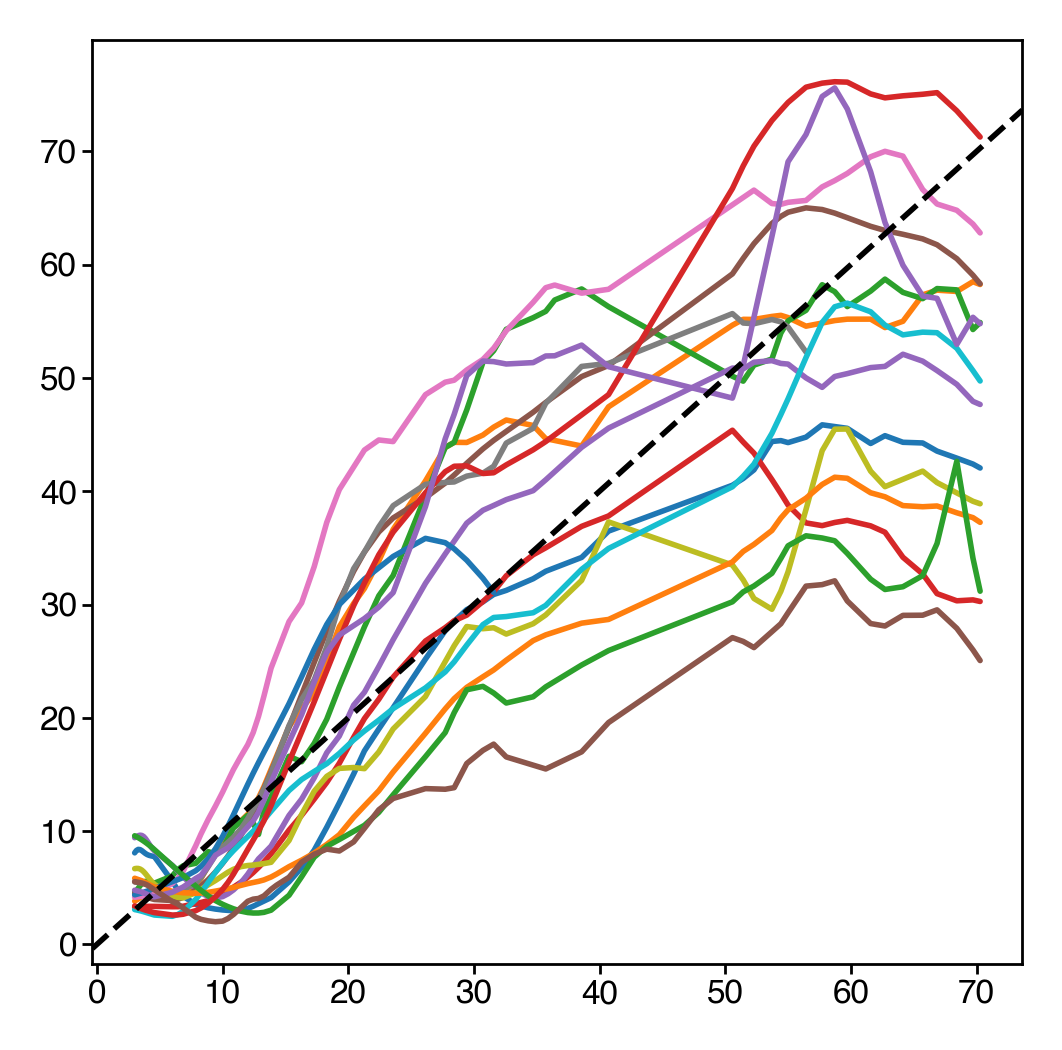

In [301]:
for k, v in mouse_pred_dict.items():
    plt.plot(v)
dotted_identity(plt.gca())

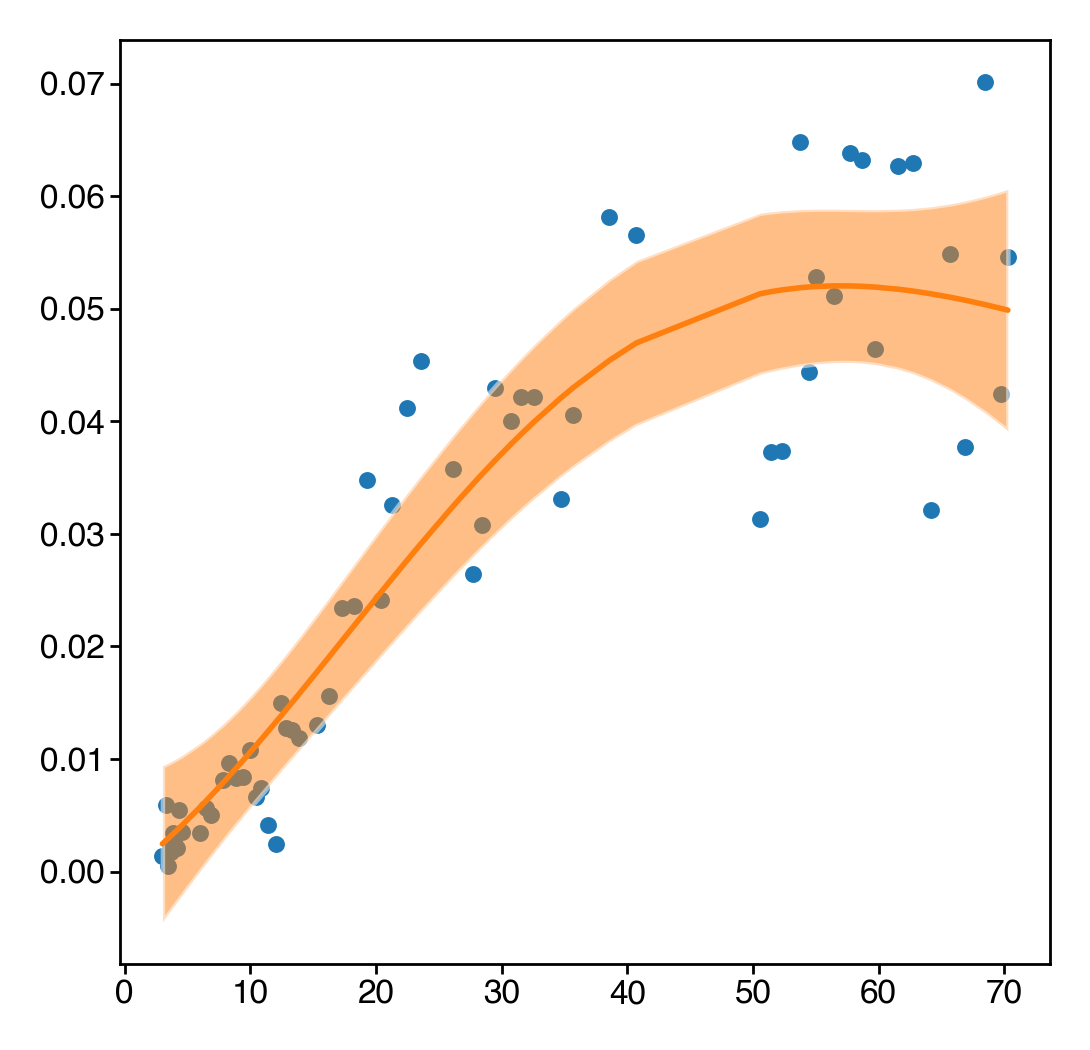

In [113]:
plt.scatter(x, y, s=5)
out, std_out = gp.predict(x.to_numpy().reshape(-1, 1), return_std=True)
plt.plot(x, out, c='C1')
plt.fill_between(x, out - (1.96 * std_out), out + (1.96 * std_out), alpha=0.5)